# Heart Sound Machine Learning Challenge

This challenge is based on the [Physionet 2016 machine learning challenge](https://physionet.org/content/challenge-2016/1.0.0/). Numerous solutions to this challenge have been published and we encourage you to take advantage of previous work. We don't expect this exercise to take more than four hours. But there is a space at the end of the notebook to discuss other techniques you would try if you had more time. 

## Training Data

The training set for this challenge consists of the training data from the Physionet 2016 minus the data included in the test set. There is a file named REFERENCE.csv containing the audio file names and the corresponding labels. The meaning of the labels are as follows: 

```
Abnormal heart sound: 1
Normal heart sound: -1 
```

While training if you would like access to GPU or TPU hardware, you can select `Change runtime type` from the `Runtime` menu and select an accelerator type under `Hardware accelerator`. 

## Test Data

The test set data consists 301 recordings from the public validation set from the Physionet 2016 challenge. This is a balanced set of 150 normal and 151 abnormal recordings. We encourage you to not use this set for hyperparameter tuning and to save it to evaluate on at the end of the challenge.

## Evaluation

Tune your solutions to maximize the area under the ROC curve for detection of abnormal heart sounds. We will attempt to evaluate your model both on the test set provided and on a hidden holdout set. 

## Deliverable

Feel free to make any changes you like to the preprocessing or the classifier. Please share your updated colab notebook with the hiring manager. To help us understand your results, you can include explanations of the experiments you've performed and improvements that you've made using the colab notebook's text blocks. There is also a text block at the end of the notebook for you to summarize your changes. 

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.io import wavfile
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras import backend as K
import tensorflow as tf

# Download and preprocess data

! wget https://eko-public.s3.amazonaws.com/heart_sound_challenge.zip
! unzip -q heart_sound_challenge.zip

In [2]:
rms = lambda x: np.sqrt(np.mean(np.square(x)));

In [3]:
def get_FFT_full(x,y):
            
    kplot = np.int(x.size/2);
    
    f     = np.zeros(kplot);
    PSD   = np.zeros(kplot);
            
    sp    = np.fft.fft(y);

    dx    = x[1]-x[0];
    scale = dx*np.sqrt(2);

    freq  = np.fft.fftfreq(x.size,d=dx);
    
    f     = freq[:kplot];
    PSD   = np.abs(sp[:kplot])*scale;
    
    return(f, PSD);

In [4]:
TRAIN_PATH = 'heart_sound_challenge/heart_sound_challenge/train/'
TEST_PATH = 'heart_sound_challenge/heart_sound_challenge/test/'

def preprocess_data(PATH):
    # Load data reference
    labels = pd.read_csv(os.path.join(PATH, 'REFERENCE.csv'))

    NSAMPLES, _ = np.shape(labels);
    mu_sig      = np.zeros(NSAMPLES);  
    FSAMP       = 2000;
    NTIME       = FSAMP*5;
    NFREQ       = int(NTIME/2);

    # Plug input data into numpy array
    x    = np.zeros((len(labels), 2000*5, 1));
    time = np.linspace(0.,5.,num=NTIME);
    FFT  = np.zeros((len(labels), NFREQ,  1));

    for k, recording_id in enumerate(labels.recording_id):
        fs, audio = wavfile.read(os.path.join(PATH, recording_id + '.wav'))

        assert(fs == 2000)
        x[k, :, 0]  = audio[:2000*5]/(2**15-1);

        # Calculate ratio of mean/ std-dev for each signal:
        mu_sig[k]   = np.mean(x[k, :, 0])/rms(x[k, :, 0]);

        x[k, :, 0] -= np.mean(x[k, :, 0]); # Zero-temporal mean for each signal
        x[k, :, 0] /= rms(x[k, :, 0]);     # Scale wrt RMS value of signal -- same as StDev for zero mean

        # Calculate FFT:
        frequency, FFT[k,:,0] = get_FFT_full(time, x[k,:,0]);

    # Plug labels into numpy array
    y = pd.get_dummies(labels.label).values

    return frequency, FFT, y, mu_sig, labels.recording_id

In [5]:
freq, FFT_train, y_train, _, ID_train = preprocess_data(TRAIN_PATH)
freq, FFT_test,  y_test,  _, ID_test  = preprocess_data(TEST_PATH)

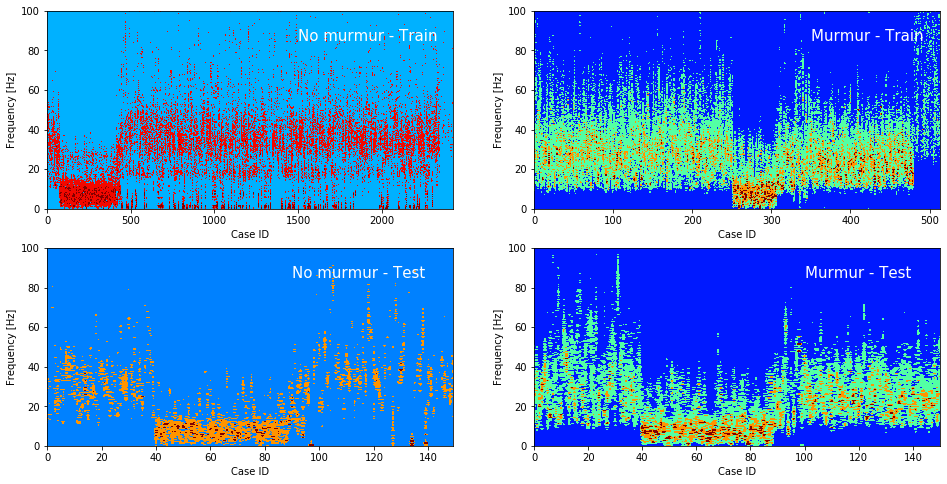

In [6]:
# Examine classwise-FFT:
F0  = FFT_train[y_train[:,0]==1,:,0];  F1  = FFT_train[y_train[:,1]==1,:,0];
F0T = FFT_test[y_test[:,0]==1,:,0];    F1T = FFT_test[y_test[:,1]==1,:,0];

plt.figure(figsize=(16,8));

plt.subplot(221);
XXcase0, XXfreq0 = np.meshgrid(np.arange(np.shape(F0)[0]),freq,indexing='ij');
plt.contourf(XXcase0,XXfreq0,(F0),cmap='jet',vmin=0.,vmax=1.);
plt.xlabel('Case ID');
plt.ylabel('Frequency [Hz]');
plt.text(1500,85,'No murmur - Train',c='w',fontsize=15)
plt.ylim([0,100]);
#plt.colorbar();

plt.subplot(222);
XXcase1, XXfreq1 = np.meshgrid(np.arange(np.shape(F1)[0]),freq,indexing='ij');
plt.contourf(XXcase1,XXfreq1,(F1),cmap='jet',vmin=0.,vmax=1.);
plt.xlabel('Case ID');
plt.ylabel('Frequency [Hz]');
plt.text(350,85,'Murmur - Train',c='w',fontsize=15)
plt.ylim([0,100]);
#plt.colorbar();

plt.subplot(223);
XXcase0, XXfreq0 = np.meshgrid(np.arange(np.shape(F0T)[0]),freq,indexing='ij');
plt.contourf(XXcase0,XXfreq0,(F0T),cmap='jet',vmin=0.,vmax=1.);
plt.xlabel('Case ID');
plt.ylabel('Frequency [Hz]');
plt.text(90,85,'No murmur - Test',c='w',fontsize=15)
plt.ylim([0,100]);
#plt.colorbar();

plt.subplot(224);
XXcase1, XXfreq1 = np.meshgrid(np.arange(np.shape(F1T)[0]),freq,indexing='ij');
plt.contourf(XXcase1,XXfreq1,(F1T),cmap='jet',vmin=0.,vmax=1.);
plt.xlabel('Case ID');
plt.ylabel('Frequency [Hz]');
plt.text(100,85,'Murmur - Test',c='w',fontsize=15)
plt.ylim([0,100]);
#plt.colorbar();

In [7]:
def threshold_spectra(frequency, fcr, F_train, F_test, interval):
    
    FFT_sort = np.sort(F_train[:,frequency<=fcr,0].flatten());
    Ns       = np.size(FFT_sort);
    interval = int((Ns*interval));
    thresh   = FFT_sort[interval];
    
    FN_train = np.zeros_like(F_train[:,frequency<=fcr,:]);
    FN_test  = np.zeros_like(F_test[:,frequency<=fcr,:]);
    
    FN_train[F_train[:,frequency<=fcr,:]>thresh] = 1.0;
    FN_test[F_test[:,frequency<=fcr,:]>thresh]   = 1.0;
    
    return(FN_train, FN_test);

# Oversample some parts of the training set:

In [8]:
def SMOTE_FFT(sig_in,NOUT,RANDSEED,KNb,threshold):
    
    np.random.seed(RANDSEED);
    M,NF,_ = np.shape(sig_in);
    
    assert(KNb < M), "ERROR: Number of sampled neighbors must be less than number of cases";
    
    sig_out = np.zeros([NOUT,NF,1]);
    
    # indices to sample
    indices = np.random.choice(np.arange(M),size=NOUT,replace=True);
    
    for i in range(NOUT):   
        # Select random entry in sig_in:
        sig  = sig_in[indices[i],:,0];
        dist = np.sum(np.abs(sig - sig_in[:,:,0]),axis=1);
        indK = np.argsort(dist)[:KNb];
        
        acoef = np.random.rand(KNb);
        acoef = acoef/np.sum(acoef);
        
        for j in range(KNb):
            sig_out[i,:,0] += acoef[j]*sig_in[indK[j],:,0];
            
    # Finally, threshold:
    sig_out[sig_out < threshold] = 0;
    sig_out[sig_out > threshold] = 1;
    
    return(sig_out);

In [9]:
xf_train, xf_test = threshold_spectra(freq,100,FFT_train,FFT_test,0.95);

ind0 = np.where(y_train[:,0]==1)[0];
ind1 = np.where(y_train[:,1]==1)[0];

# Oversample training dataset:
ist     = 125; iend = 375;
NAV     = iend-ist;
NSYN0   = int((np.size(ind0)-2*NAV)/2)
xf_syn0 = SMOTE_FFT(xf_train[ind0[ist:iend],:,:], NSYN0, 1000, 1, 0.50);

ist     = 250; iend = 300;
NAV     = iend-ist;
NSYN1   = int((np.size(ind1)-2*NAV)/2)
xf_syn1 = SMOTE_FFT(xf_train[ind1[ist:iend],:,:], NSYN1, 1000, 1, 0.50);

xff_train = xf_train.copy();
yff_train = y_train.copy();

xff_train = np.append(xf_train, xf_syn0,axis=0)
xff_train = np.append(xff_train,xf_syn1,axis=0)

for i in range(NSYN0):
    yff_train = np.append(yff_train,[[1,0]],axis=0);
for i in range(NSYN1):
    yff_train = np.append(yff_train,[[0,1]],axis=0);


print(xff_train.shape)

(4108, 501, 1)


# Train a convolutional neural network model

For simplicity, we have defined this CNN in keras. But feel free to translate to the framework of your choice.

I stuck mainly to the same CNN architecture in terms of layers, but did a grid search CV to determine good hyperparameters.  

In [10]:
def create_CNN_model_general(Xshape, filters=16, KernSz=3, num_classes=2, dropout_rate=0.50):
    
    model = Sequential()
    model.add(Conv1D(filters, KernSz, activation='relu', input_shape=(Xshape, 1)))
    model.add(Conv1D(filters, KernSz, activation='relu'))
    model.add(MaxPooling1D(pool_size=(KernSz)))

    model.add(Conv1D(2*filters, KernSz, activation='relu'))
    model.add(Conv1D(2*filters, KernSz, activation='relu'))
    model.add(MaxPooling1D(pool_size=(KernSz)))

    model.add(Conv1D(4*filters, KernSz, activation='relu'))
    model.add(Conv1D(4*filters, KernSz, activation='relu'))
    model.add(MaxPooling1D(pool_size=(KernSz)))

    model.add(Conv1D(4*filters, KernSz, activation='relu'))
    model.add(Conv1D(4*filters, KernSz, activation='relu'))
    model.add(MaxPooling1D(pool_size=(KernSz)))

    model.add(Flatten())
    model.add(Dense(4*filters, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation=Activation(tf.nn.softmax)))
    
    model.compile(
        loss=keras.losses.categorical_crossentropy,
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['accuracy'],
    )
    #model.summary()
    
    return(model);

In [11]:
modelT = create_CNN_model_general(Xshape=xff_train.shape[1], filters=16, KernSz=3, num_classes=2, dropout_rate=0.5);

for layer in modelT.layers:
    print(layer.output.name, layer.output.shape)

conv1d/Relu:0 (None, 499, 16)
conv1d_1/Relu:0 (None, 497, 16)
max_pooling1d/Squeeze:0 (None, 165, 16)
conv1d_2/Relu:0 (None, 163, 32)
conv1d_3/Relu:0 (None, 161, 32)
max_pooling1d_1/Squeeze:0 (None, 53, 32)
conv1d_4/Relu:0 (None, 51, 64)
conv1d_5/Relu:0 (None, 49, 64)
max_pooling1d_2/Squeeze:0 (None, 16, 64)
conv1d_6/Relu:0 (None, 14, 64)
conv1d_7/Relu:0 (None, 12, 64)
max_pooling1d_3/Squeeze:0 (None, 4, 64)
flatten/Reshape:0 (None, 256)
dense/Relu:0 (None, 64)
dropout/Identity:0 (None, 64)
dense_1/activation/Softmax:0 (None, 2)


In [12]:
NTrials = 50;
epochs  = 10;
batch_size = 128;

TPRT_ar  = np.zeros([250,NTrials]);
FPRT_ar  = np.zeros([250,NTrials]);
AUCT_ar  = np.zeros([NTrials]);
sizeT_ar = np.zeros([NTrials],dtype=int);
randarr = np.random.randint(0,10000,NTrials);

print(randarr);

[6810 9722  276  324 4726 1780 4163 2035 4298 5838  602 1751 4640  910
 5304 4091  793 7897 2263 9903 7843 5340   22 8609 3981 9520 5438 4709
 9620 7859 7533 4009 9877 2722 3558 6681 9266 7129 2003 6268 6647 6660
 3583 6400 2973 4767 7212 4792 4326 4153]


# Assess performance of proposed strategy:

In [13]:
for itrial in range(NTrials):
    
    print('Trial: ', itrial+1);
    
    np.random.seed(randarr[itrial]);
    tf.compat.v1.set_random_seed(randarr[itrial]);
        
    modelT = create_CNN_model_general(Xshape=xff_train.shape[1], filters=16, KernSz=3, num_classes=2, dropout_rate=0.5);

    history = modelT.fit(
        xff_train, 
        yff_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        shuffle=True,
    )

    yT_pred = modelT.predict(xf_test)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test[:, 0], yT_pred[:, 0]);
    auc = roc_auc_score(y_test[:, 0], yT_pred[:, 0]);
    
    sizeT_ar[itrial] = np.size(true_positive_rate);
    
    TPRT_ar[:np.size(true_positive_rate),itrial] = true_positive_rate;
    FPRT_ar[:np.size(true_positive_rate),itrial] = false_positive_rate;
    
    AUCT_ar[itrial] = auc;
    
    print('')

Trial:  1
Epoch 1/10
33/33 [==============================] - 2s 35ms/step - loss: 0.5070 - accuracy: 0.8191
Epoch 2/10
33/33 [==============================] - 1s 36ms/step - loss: 0.4385 - accuracy: 0.8245
Epoch 3/10
33/33 [==============================] - 1s 35ms/step - loss: 0.4190 - accuracy: 0.8291
Epoch 4/10
33/33 [==============================] - 1s 36ms/step - loss: 0.3990 - accuracy: 0.8342
Epoch 5/10
33/33 [==============================] - 1s 35ms/step - loss: 0.3850 - accuracy: 0.8408
Epoch 6/10
33/33 [==============================] - 1s 35ms/step - loss: 0.3793 - accuracy: 0.8423
Epoch 7/10
33/33 [==============================] - 1s 35ms/step - loss: 0.3731 - accuracy: 0.8464
Epoch 8/10
33/33 [==============================] - 1s 36ms/step - loss: 0.3588 - accuracy: 0.8544
Epoch 9/10
33/33 [==============================] - 1s 36ms/step - loss: 0.3446 - accuracy: 0.8544
Epoch 10/10
33/33 [==============================] - 1s 35ms/step - loss: 0.3210 - accuracy: 0.8632

33/33 [==============================] - 1s 36ms/step - loss: 0.4551 - accuracy: 0.8245
Epoch 3/10
33/33 [==============================] - 1s 36ms/step - loss: 0.4061 - accuracy: 0.8235
Epoch 4/10
33/33 [==============================] - 1s 36ms/step - loss: 0.3954 - accuracy: 0.8328
Epoch 5/10
33/33 [==============================] - 1s 36ms/step - loss: 0.3798 - accuracy: 0.8413
Epoch 6/10
33/33 [==============================] - 1s 36ms/step - loss: 0.3778 - accuracy: 0.8457
Epoch 7/10
33/33 [==============================] - 1s 36ms/step - loss: 0.3709 - accuracy: 0.8503
Epoch 8/10
33/33 [==============================] - 1s 36ms/step - loss: 0.3462 - accuracy: 0.8571
Epoch 9/10
33/33 [==============================] - 1s 36ms/step - loss: 0.3288 - accuracy: 0.8659
Epoch 10/10
33/33 [==============================] - 1s 36ms/step - loss: 0.3027 - accuracy: 0.8746

Trial:  10
Epoch 1/10
33/33 [==============================] - 2s 36ms/step - loss: 0.5160 - accuracy: 0.8084
Epoch 2/

33/33 [==============================] - 1s 35ms/step - loss: 0.4387 - accuracy: 0.8245
Epoch 4/10
33/33 [==============================] - 1s 35ms/step - loss: 0.4071 - accuracy: 0.8315
Epoch 5/10
33/33 [==============================] - 1s 35ms/step - loss: 0.3941 - accuracy: 0.8313
Epoch 6/10
33/33 [==============================] - 1s 35ms/step - loss: 0.3847 - accuracy: 0.8410
Epoch 7/10
33/33 [==============================] - 1s 35ms/step - loss: 0.3743 - accuracy: 0.8476
Epoch 8/10
33/33 [==============================] - 1s 35ms/step - loss: 0.3599 - accuracy: 0.8522
Epoch 9/10
33/33 [==============================] - 1s 36ms/step - loss: 0.3463 - accuracy: 0.8513
Epoch 10/10
33/33 [==============================] - 1s 35ms/step - loss: 0.3238 - accuracy: 0.8668

Trial:  18
Epoch 1/10
33/33 [==============================] - 2s 35ms/step - loss: 0.5203 - accuracy: 0.8055
Epoch 2/10
33/33 [==============================] - 1s 36ms/step - loss: 0.4539 - accuracy: 0.8245
Epoch 3/

33/33 [==============================] - 1s 36ms/step - loss: 0.3936 - accuracy: 0.8362
Epoch 5/10
33/33 [==============================] - 1s 36ms/step - loss: 0.3813 - accuracy: 0.8420
Epoch 6/10
33/33 [==============================] - 1s 36ms/step - loss: 0.3735 - accuracy: 0.8505
Epoch 7/10
33/33 [==============================] - 1s 36ms/step - loss: 0.3578 - accuracy: 0.8535
Epoch 8/10
33/33 [==============================] - 1s 36ms/step - loss: 0.3419 - accuracy: 0.8615
Epoch 9/10
33/33 [==============================] - 1s 36ms/step - loss: 0.3237 - accuracy: 0.8729
Epoch 10/10
33/33 [==============================] - 1s 36ms/step - loss: 0.3138 - accuracy: 0.8710

Trial:  26
Epoch 1/10
33/33 [==============================] - 2s 35ms/step - loss: 0.5194 - accuracy: 0.8157
Epoch 2/10
33/33 [==============================] - 1s 35ms/step - loss: 0.4591 - accuracy: 0.8245
Epoch 3/10
33/33 [==============================] - 1s 35ms/step - loss: 0.4237 - accuracy: 0.8259
Epoch 4/

33/33 [==============================] - 1s 35ms/step - loss: 0.3791 - accuracy: 0.8566
Epoch 6/10
33/33 [==============================] - 1s 35ms/step - loss: 0.3607 - accuracy: 0.8542
Epoch 7/10
33/33 [==============================] - 1s 35ms/step - loss: 0.3460 - accuracy: 0.8634
Epoch 8/10
33/33 [==============================] - 1s 38ms/step - loss: 0.3323 - accuracy: 0.8681
Epoch 9/10
33/33 [==============================] - 1s 37ms/step - loss: 0.3229 - accuracy: 0.8707
Epoch 10/10
33/33 [==============================] - 1s 37ms/step - loss: 0.3040 - accuracy: 0.8773

Trial:  34
Epoch 1/10
33/33 [==============================] - 2s 41ms/step - loss: 0.5258 - accuracy: 0.8111
Epoch 2/10
33/33 [==============================] - 1s 39ms/step - loss: 0.4592 - accuracy: 0.8245
Epoch 3/10
33/33 [==============================] - 1s 40ms/step - loss: 0.4128 - accuracy: 0.8284
Epoch 4/10
33/33 [==============================] - 1s 40ms/step - loss: 0.4007 - accuracy: 0.8367
Epoch 5/

33/33 [==============================] - 1s 36ms/step - loss: 0.3937 - accuracy: 0.8347
Epoch 7/10
33/33 [==============================] - 1s 35ms/step - loss: 0.3770 - accuracy: 0.8403
Epoch 8/10
33/33 [==============================] - 1s 36ms/step - loss: 0.3659 - accuracy: 0.8479
Epoch 9/10
33/33 [==============================] - 1s 36ms/step - loss: 0.3450 - accuracy: 0.8493
Epoch 10/10
33/33 [==============================] - 1s 36ms/step - loss: 0.3316 - accuracy: 0.8605

Trial:  42
Epoch 1/10
33/33 [==============================] - 2s 35ms/step - loss: 0.5222 - accuracy: 0.8101
Epoch 2/10
33/33 [==============================] - 1s 35ms/step - loss: 0.4526 - accuracy: 0.8245
Epoch 3/10
33/33 [==============================] - 1s 35ms/step - loss: 0.4192 - accuracy: 0.8242
Epoch 4/10
33/33 [==============================] - 1s 35ms/step - loss: 0.4007 - accuracy: 0.8311
Epoch 5/10
33/33 [==============================] - 1s 35ms/step - loss: 0.3862 - accuracy: 0.8452
Epoch 6/

33/33 [==============================] - 1s 38ms/step - loss: 0.3398 - accuracy: 0.8586
Epoch 8/10
33/33 [==============================] - 1s 36ms/step - loss: 0.3258 - accuracy: 0.8649
Epoch 9/10
33/33 [==============================] - 1s 38ms/step - loss: 0.2947 - accuracy: 0.8734
Epoch 10/10
33/33 [==============================] - 1s 42ms/step - loss: 0.2621 - accuracy: 0.8905

Trial:  50
Epoch 1/10
33/33 [==============================] - 2s 43ms/step - loss: 0.5295 - accuracy: 0.8062
Epoch 2/10
33/33 [==============================] - 1s 43ms/step - loss: 0.4463 - accuracy: 0.8250
Epoch 3/10
33/33 [==============================] - 1s 44ms/step - loss: 0.4092 - accuracy: 0.8269
Epoch 4/10
33/33 [==============================] - 2s 46ms/step - loss: 0.3937 - accuracy: 0.8352
Epoch 5/10
33/33 [==============================] - 1s 44ms/step - loss: 0.3850 - accuracy: 0.8435
Epoch 6/10
33/33 [==============================] - 1s 44ms/step - loss: 0.3723 - accuracy: 0.8466
Epoch 7/

[0.74459161 0.73602649 0.75381898 0.67827815 0.7380574  0.75306843
 0.73006623 0.73011038 0.70375276 0.7216777  0.69324503 0.74198675
 0.74834437 0.69037528 0.67492274 0.73699779 0.74013245 0.74843267
 0.70339956 0.74662252 0.73364238 0.75854305 0.74927152 0.73907285
 0.73465784 0.72887417 0.74317881 0.74772627 0.73077263 0.74419426
 0.71134658 0.75033113 0.72631347 0.74507726 0.73064018 0.73549669
 0.75108168 0.6998234  0.74940397 0.6997351  0.71624724 0.72556291
 0.72816777 0.74507726 0.63368653 0.73509934 0.72874172 0.73871965
 0.72388521 0.74781457]


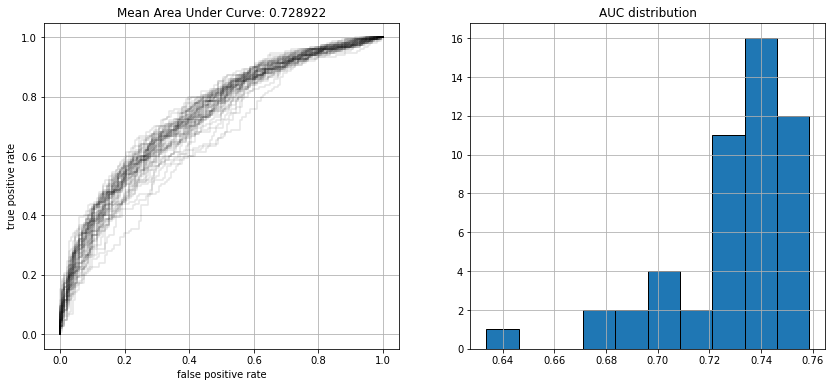

In [14]:
print(AUCT_ar)

plt.figure(figsize=(14,6));
plt.subplot(121);
for i in range(NTrials):
    plt.plot(FPRT_ar[:sizeT_ar[i],i], TPRT_ar[:sizeT_ar[i],i], 'k-', alpha=0.1);
plt.grid(True);
plt.xlabel('false positive rate');
plt.ylabel('true positive rate');
plt.title('Mean Area Under Curve: %f' % np.mean(AUCT_ar));

plt.subplot(122);
plt.hist(AUCT_ar,edgecolor='k');
plt.title('AUC distribution');
plt.grid(True);

# Clustering to remove "bad" signals:

In [15]:
from sklearn.cluster import KMeans
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [16]:
NTRAIN, NFQ, _ = xf_train.shape;
NTEST, _, _    = xf_test.shape;

KMc = KMeans(n_clusters=2,random_state=0).fit(xf_train[:,:,0]);

lab_train = KMc.labels_;
lab_test  = KMc.predict(xf_test[:,:,0]);

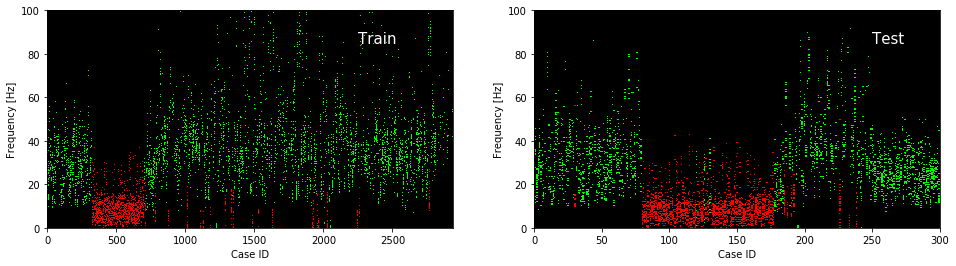

In [17]:
xfc_train = np.zeros_like(xf_train);
xfc_test = np.zeros_like(xf_test);

for i in range(NTRAIN):
    xfc_train[i,:,0] = xf_train[i,:,0]*(lab_train[i]+1);
for i in range(NTEST):
    xfc_test[i,:,0]  = xf_test[i,:,0]*(lab_test[i]+1);
    
# Define colormaps:
myCmp = ListedColormap(np.array([ [0,0,0], [1,0,0], [0,1,0] ],dtype=float));
    
plt.figure(figsize=(16,4));
plt.subplot(121);
XXcase, XXfreq = np.meshgrid(np.arange(NTRAIN),freq[freq<=100],indexing='ij');
plt.pcolormesh(XXcase,XXfreq,xfc_train[:,:,0],cmap=myCmp);
#plt.pcolormesh(XXcase,XXfreq,xf_train[:,:,0],cmap='gray');
plt.xlabel('Case ID');
plt.ylabel('Frequency [Hz]');
plt.ylim([0,100]);
plt.text(2250,85,'Train',c='w',fontsize=15)


plt.subplot(122);
XXcase, XXfreq = np.meshgrid(np.arange(NTEST),freq[freq<=100],indexing='ij');
plt.pcolormesh(XXcase,XXfreq,xfc_test[:,:,0],cmap=myCmp);
#plt.pcolormesh(XXcase,XXfreq,xf_test[:,:,0],cmap='gray');
plt.xlabel('Case ID');
plt.ylabel('Frequency [Hz]');
plt.ylim([0,100]);
plt.text(250,85,'Test',c='w',fontsize=15);

In [18]:
NTrials = 50;
epochs  = 10;
batch_size = 128;

TPRTT_ar  = np.zeros([250,NTrials]);
FPRTT_ar  = np.zeros([250,NTrials]);
AUCTT_ar  = np.zeros([NTrials]);
sizeTT_ar = np.zeros([NTrials],dtype=int);

# Remove bad cases:
xft_train = xf_train[lab_train==1,:,:]; yft_train = y_train[lab_train==1,:];
xft_test  =  xf_test[lab_test==1,:,:];   yft_test =  y_test[lab_test==1,:];

In [19]:
for itrial in range(NTrials):
    
    print('Trial: ', itrial+1);
    
    np.random.seed(randarr[itrial]);
    tf.compat.v1.set_random_seed(randarr[itrial]);
        
    modelTT = create_CNN_model_general(Xshape=xft_train.shape[1], filters=16, KernSz=3, num_classes=2, dropout_rate=0.5);

    history = modelTT.fit(
        xft_train, 
        yft_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        shuffle=True,
    )

    yft_pred = modelTT.predict(xft_test)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(yft_test[:, 0], yft_pred[:, 0]);
    auc = roc_auc_score(yft_test[:, 0], yft_pred[:, 0]);
    
    sizeTT_ar[itrial] = np.size(true_positive_rate);
    
    TPRTT_ar[:np.size(true_positive_rate),itrial] = true_positive_rate;
    FPRTT_ar[:np.size(true_positive_rate),itrial] = false_positive_rate;
    
    AUCTT_ar[itrial] = auc;
    
    print('')

Trial:  1
Epoch 1/10
20/20 [==============================] - 1s 43ms/step - loss: 0.5233 - accuracy: 0.8071
Epoch 2/10
20/20 [==============================] - 1s 43ms/step - loss: 0.4279 - accuracy: 0.8178
Epoch 3/10
20/20 [==============================] - 1s 43ms/step - loss: 0.3872 - accuracy: 0.8247
Epoch 4/10
20/20 [==============================] - 1s 43ms/step - loss: 0.3547 - accuracy: 0.8497
Epoch 5/10
20/20 [==============================] - 1s 42ms/step - loss: 0.3415 - accuracy: 0.8563
Epoch 6/10
20/20 [==============================] - 1s 42ms/step - loss: 0.3350 - accuracy: 0.8669
Epoch 7/10
20/20 [==============================] - 1s 42ms/step - loss: 0.3417 - accuracy: 0.8620
Epoch 8/10
20/20 [==============================] - 1s 42ms/step - loss: 0.3229 - accuracy: 0.8677 0s - loss: 0.3294 - accu
Epoch 9/10
20/20 [==============================] - 1s 43ms/step - loss: 0.3142 - accuracy: 0.8731
Epoch 10/10
20/20 [==============================] - 1s 43ms/step - loss: 

20/20 [==============================] - 1s 44ms/step - loss: 0.5137 - accuracy: 0.8108
Epoch 2/10
20/20 [==============================] - 1s 44ms/step - loss: 0.4180 - accuracy: 0.8198
Epoch 3/10
20/20 [==============================] - 1s 42ms/step - loss: 0.3776 - accuracy: 0.8387
Epoch 4/10
20/20 [==============================] - 1s 43ms/step - loss: 0.3450 - accuracy: 0.8649
Epoch 5/10
20/20 [==============================] - 1s 42ms/step - loss: 0.3363 - accuracy: 0.8620
Epoch 6/10
20/20 [==============================] - 1s 43ms/step - loss: 0.3294 - accuracy: 0.8640
Epoch 7/10
20/20 [==============================] - 1s 43ms/step - loss: 0.3250 - accuracy: 0.8649
Epoch 8/10
20/20 [==============================] - 1s 43ms/step - loss: 0.3166 - accuracy: 0.8714
Epoch 9/10
20/20 [==============================] - 1s 44ms/step - loss: 0.3149 - accuracy: 0.8636
Epoch 10/10
20/20 [==============================] - 1s 43ms/step - loss: 0.3055 - accuracy: 0.8735

Trial:  10
Epoch 1/

20/20 [==============================] - 1s 34ms/step - loss: 0.4646 - accuracy: 0.8137
Epoch 3/10
20/20 [==============================] - 1s 36ms/step - loss: 0.4013 - accuracy: 0.8137
Epoch 4/10
20/20 [==============================] - 1s 36ms/step - loss: 0.3746 - accuracy: 0.8157
Epoch 5/10
20/20 [==============================] - 1s 37ms/step - loss: 0.3591 - accuracy: 0.8382
Epoch 6/10
20/20 [==============================] - 1s 39ms/step - loss: 0.3446 - accuracy: 0.8554
Epoch 7/10
20/20 [==============================] - 1s 38ms/step - loss: 0.3330 - accuracy: 0.8632
Epoch 8/10
20/20 [==============================] - 1s 37ms/step - loss: 0.3393 - accuracy: 0.8665
Epoch 9/10
20/20 [==============================] - 1s 35ms/step - loss: 0.3159 - accuracy: 0.8714
Epoch 10/10
20/20 [==============================] - 1s 35ms/step - loss: 0.3090 - accuracy: 0.8702

Trial:  18
Epoch 1/10
20/20 [==============================] - 1s 33ms/step - loss: 0.5413 - accuracy: 0.7899
Epoch 2/

20/20 [==============================] - 1s 37ms/step - loss: 0.3789 - accuracy: 0.8419
Epoch 4/10
20/20 [==============================] - 1s 35ms/step - loss: 0.3665 - accuracy: 0.8428
Epoch 5/10
20/20 [==============================] - 1s 35ms/step - loss: 0.3559 - accuracy: 0.8395
Epoch 6/10
20/20 [==============================] - 1s 36ms/step - loss: 0.3523 - accuracy: 0.8546
Epoch 7/10
20/20 [==============================] - 1s 36ms/step - loss: 0.3404 - accuracy: 0.8600
Epoch 8/10
20/20 [==============================] - 1s 35ms/step - loss: 0.3284 - accuracy: 0.8645
Epoch 9/10
20/20 [==============================] - 1s 36ms/step - loss: 0.3176 - accuracy: 0.8706
Epoch 10/10
20/20 [==============================] - 1s 35ms/step - loss: 0.3137 - accuracy: 0.8694

Trial:  26
Epoch 1/10
20/20 [==============================] - 1s 35ms/step - loss: 0.5411 - accuracy: 0.7969
Epoch 2/10
20/20 [==============================] - 1s 35ms/step - loss: 0.4442 - accuracy: 0.8141
Epoch 3/

20/20 [==============================] - 1s 37ms/step - loss: 0.3550 - accuracy: 0.8501
Epoch 5/10
20/20 [==============================] - 1s 35ms/step - loss: 0.3450 - accuracy: 0.8600
Epoch 6/10
20/20 [==============================] - 1s 38ms/step - loss: 0.3544 - accuracy: 0.8575
Epoch 7/10
20/20 [==============================] - 1s 35ms/step - loss: 0.3354 - accuracy: 0.8567
Epoch 8/10
20/20 [==============================] - 1s 35ms/step - loss: 0.3247 - accuracy: 0.8686
Epoch 9/10
20/20 [==============================] - 1s 35ms/step - loss: 0.3184 - accuracy: 0.8690
Epoch 10/10
20/20 [==============================] - 1s 35ms/step - loss: 0.3145 - accuracy: 0.8722

Trial:  34
Epoch 1/10
20/20 [==============================] - 1s 35ms/step - loss: 0.5350 - accuracy: 0.8002
Epoch 2/10
20/20 [==============================] - 1s 35ms/step - loss: 0.4441 - accuracy: 0.8182
Epoch 3/10
20/20 [==============================] - 1s 35ms/step - loss: 0.4015 - accuracy: 0.8276
Epoch 4/

20/20 [==============================] - 1s 35ms/step - loss: 0.3505 - accuracy: 0.8657
Epoch 6/10
20/20 [==============================] - 1s 35ms/step - loss: 0.3556 - accuracy: 0.8493
Epoch 7/10
20/20 [==============================] - 1s 35ms/step - loss: 0.3385 - accuracy: 0.8681
Epoch 8/10
20/20 [==============================] - 1s 35ms/step - loss: 0.3295 - accuracy: 0.8714
Epoch 9/10
20/20 [==============================] - 1s 35ms/step - loss: 0.3247 - accuracy: 0.8600
Epoch 10/10
20/20 [==============================] - 1s 35ms/step - loss: 0.3119 - accuracy: 0.8702

Trial:  42
Epoch 1/10
20/20 [==============================] - 1s 35ms/step - loss: 0.5488 - accuracy: 0.7957
Epoch 2/10
20/20 [==============================] - 1s 35ms/step - loss: 0.4520 - accuracy: 0.8133
Epoch 3/10
20/20 [==============================] - 1s 35ms/step - loss: 0.4048 - accuracy: 0.8194
Epoch 4/10
20/20 [==============================] - 1s 35ms/step - loss: 0.3807 - accuracy: 0.8288
Epoch 5/

20/20 [==============================] - 1s 35ms/step - loss: 0.3422 - accuracy: 0.8583
Epoch 7/10
20/20 [==============================] - 1s 35ms/step - loss: 0.3466 - accuracy: 0.8493
Epoch 8/10
20/20 [==============================] - 1s 35ms/step - loss: 0.3356 - accuracy: 0.8550
Epoch 9/10
20/20 [==============================] - 1s 35ms/step - loss: 0.3219 - accuracy: 0.8669
Epoch 10/10
20/20 [==============================] - 1s 35ms/step - loss: 0.3206 - accuracy: 0.8743

Trial:  50
Epoch 1/10
20/20 [==============================] - 1s 36ms/step - loss: 0.5552 - accuracy: 0.7789
Epoch 2/10
20/20 [==============================] - 1s 35ms/step - loss: 0.4272 - accuracy: 0.8186
Epoch 3/10
20/20 [==============================] - 1s 35ms/step - loss: 0.3762 - accuracy: 0.8391
Epoch 4/10
20/20 [==============================] - 1s 35ms/step - loss: 0.3530 - accuracy: 0.8571
Epoch 5/10
20/20 [==============================] - 1s 35ms/step - loss: 0.3500 - accuracy: 0.8567
Epoch 6/

[0.78179757 0.79437229 0.79282622 0.79818594 0.80045351 0.79282622
 0.79014636 0.80055659 0.78777572 0.79354772 0.79231086 0.79241394
 0.79241394 0.77736549 0.78550814 0.79231086 0.77860235 0.78354978
 0.77849928 0.789631   0.7831375  0.80045351 0.79437229 0.78643579
 0.79859823 0.78540507 0.79014636 0.77880849 0.7755102  0.78901257
 0.78334364 0.80024737 0.78983715 0.79911358 0.78406514 0.80169037
 0.79983509 0.78612657 0.78076685 0.79473304 0.76736755 0.77973614
 0.79375387 0.78736343 0.78468357 0.78808493 0.77963307 0.77922078
 0.78911565 0.77746856]


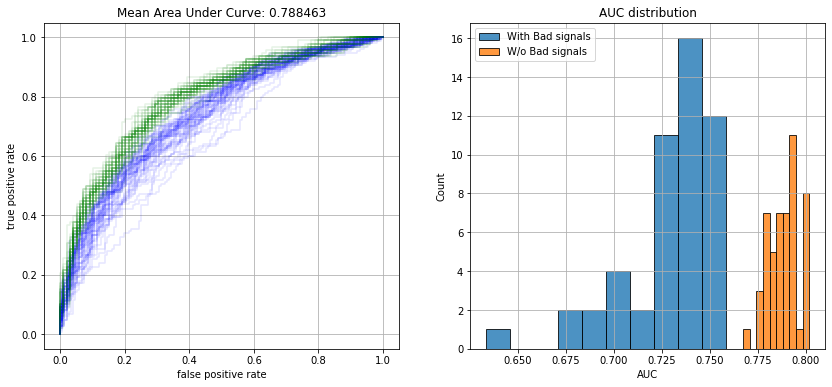

In [20]:
print(AUCTT_ar)

plt.figure(figsize=(14,6));
plt.subplot(121);
for i in range(NTrials):
    plt.plot(FPRT_ar[:sizeT_ar[i],i], TPRT_ar[:sizeT_ar[i],i], 'b-', alpha=0.1);
    plt.plot(FPRTT_ar[:sizeTT_ar[i],i], TPRTT_ar[:sizeTT_ar[i],i], 'g-', alpha=0.1);
plt.grid(True);
plt.xlabel('false positive rate');
plt.ylabel('true positive rate');
plt.title('Mean Area Under Curve: %f' % np.mean(AUCTT_ar));

plt.subplot(122);
plt.hist(AUCT_ar,edgecolor='k',alpha=0.8,label='With Bad signals');
plt.hist(AUCTT_ar,edgecolor='k',alpha=0.8,label='W/o Bad signals');
plt.title('AUC distribution');
plt.xlabel('AUC');
plt.ylabel('Count')
plt.grid(True);
plt.legend();

# Balanced Dataset:

In [21]:
xft1       = xft_train[yft_train[:,1]==1,:,:];
NFT0, _, _  = np.shape(xft_train[yft_train[:,0]==1,:,:]); 
NFT1, _, _ = np.shape(xft1);

NSYN = NFT0-NFT1;

xft_syn1    = SMOTE_FFT(xft1, NSYN, 1000, 1, 0.50);
xbal_train  = np.append(xft_train, xft_syn1,axis=0)

ybal_train = yft_train.copy();
for i in range(NSYN):
    ybal_train = np.append(ybal_train,[[0,1]],axis=0);

print(xbal_train.shape, ybal_train.shape)

(3974, 501, 1) (3974, 2)


In [22]:
NTrials = 50;
epochs  = 10;
batch_size = 128;

TPRB_ar  = np.zeros([250,NTrials]);
FPRB_ar  = np.zeros([250,NTrials]);
AUCB_ar  = np.zeros([NTrials]);
sizeB_ar = np.zeros([NTrials],dtype=int);

In [23]:
for itrial in range(NTrials):
    
    print('Trial: ', itrial+1);
    
    np.random.seed(randarr[itrial]);
    tf.compat.v1.set_random_seed(randarr[itrial]);
        
    modelB = create_CNN_model_general(Xshape=xbal_train.shape[1], filters=16, KernSz=3, num_classes=2, dropout_rate=0.5);

    history = modelB.fit(
        xbal_train, 
        ybal_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        shuffle=True,
    )

    ybal_pred = modelB.predict(xft_test)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(yft_test[:, 0], ybal_pred[:, 0]);
    auc = roc_auc_score(yft_test[:, 0], ybal_pred[:, 0]);
    
    sizeB_ar[itrial] = np.size(true_positive_rate);
    
    TPRB_ar[:np.size(true_positive_rate),itrial] = true_positive_rate;
    FPRB_ar[:np.size(true_positive_rate),itrial] = false_positive_rate;
    
    AUCB_ar[itrial] = auc;
    
    print('')

Trial:  1
Epoch 1/10
32/32 [==============================] - 2s 36ms/step - loss: 0.5739 - accuracy: 0.7167
Epoch 2/10
32/32 [==============================] - 1s 36ms/step - loss: 0.4794 - accuracy: 0.7776
Epoch 3/10
32/32 [==============================] - 1s 36ms/step - loss: 0.4476 - accuracy: 0.7969
Epoch 4/10
32/32 [==============================] - 1s 36ms/step - loss: 0.4659 - accuracy: 0.7876
Epoch 5/10
32/32 [==============================] - 1s 36ms/step - loss: 0.4129 - accuracy: 0.8166
Epoch 6/10
32/32 [==============================] - 1s 36ms/step - loss: 0.3885 - accuracy: 0.8342
Epoch 7/10
32/32 [==============================] - 1s 36ms/step - loss: 0.3788 - accuracy: 0.8354
Epoch 8/10
32/32 [==============================] - 1s 36ms/step - loss: 0.3498 - accuracy: 0.8551
Epoch 9/10
32/32 [==============================] - 1s 36ms/step - loss: 0.3341 - accuracy: 0.8616
Epoch 10/10
32/32 [==============================] - 1s 36ms/step - loss: 0.3080 - accuracy: 0.8729

32/32 [==============================] - 1s 35ms/step - loss: 0.4868 - accuracy: 0.7698
Epoch 3/10
32/32 [==============================] - 1s 36ms/step - loss: 0.4533 - accuracy: 0.7894
Epoch 4/10
32/32 [==============================] - 1s 36ms/step - loss: 0.4593 - accuracy: 0.7879 0s - los
Epoch 5/10
32/32 [==============================] - 1s 34ms/step - loss: 0.4292 - accuracy: 0.8100
Epoch 6/10
32/32 [==============================] - 1s 33ms/step - loss: 0.4156 - accuracy: 0.8168
Epoch 7/10
32/32 [==============================] - 1s 35ms/step - loss: 0.3849 - accuracy: 0.8367
Epoch 8/10
32/32 [==============================] - 1s 34ms/step - loss: 0.3530 - accuracy: 0.8513
Epoch 9/10
32/32 [==============================] - 1s 36ms/step - loss: 0.3458 - accuracy: 0.8616
Epoch 10/10
32/32 [==============================] - 1s 34ms/step - loss: 0.3343 - accuracy: 0.8613

Trial:  10
Epoch 1/10
32/32 [==============================] - 2s 35ms/step - loss: 0.5730 - accuracy: 0.7134

32/32 [==============================] - 1s 35ms/step - loss: 0.5062 - accuracy: 0.7720
Epoch 4/10
32/32 [==============================] - 1s 35ms/step - loss: 0.4534 - accuracy: 0.7944
Epoch 5/10
32/32 [==============================] - 1s 35ms/step - loss: 0.4405 - accuracy: 0.8002
Epoch 6/10
32/32 [==============================] - 1s 35ms/step - loss: 0.4335 - accuracy: 0.8032
Epoch 7/10
32/32 [==============================] - 1s 35ms/step - loss: 0.4173 - accuracy: 0.8135
Epoch 8/10
32/32 [==============================] - 1s 34ms/step - loss: 0.3844 - accuracy: 0.8344
Epoch 9/10
32/32 [==============================] - 1s 35ms/step - loss: 0.3752 - accuracy: 0.8357
Epoch 10/10
32/32 [==============================] - 1s 35ms/step - loss: 0.3493 - accuracy: 0.8488

Trial:  18
Epoch 1/10
32/32 [==============================] - 2s 36ms/step - loss: 0.5708 - accuracy: 0.7021
Epoch 2/10
32/32 [==============================] - 1s 36ms/step - loss: 0.4873 - accuracy: 0.7773
Epoch 3/

32/32 [==============================] - 1s 35ms/step - loss: 0.4321 - accuracy: 0.8083
Epoch 5/10
32/32 [==============================] - 1s 35ms/step - loss: 0.4252 - accuracy: 0.8226
Epoch 6/10
32/32 [==============================] - 1s 35ms/step - loss: 0.3904 - accuracy: 0.8357
Epoch 7/10
32/32 [==============================] - 1s 35ms/step - loss: 0.4004 - accuracy: 0.8251
Epoch 8/10
32/32 [==============================] - 1s 35ms/step - loss: 0.3600 - accuracy: 0.8463
Epoch 9/10
32/32 [==============================] - 1s 37ms/step - loss: 0.3348 - accuracy: 0.8636
Epoch 10/10
32/32 [==============================] - 1s 39ms/step - loss: 0.2949 - accuracy: 0.8810

Trial:  26
Epoch 1/10
32/32 [==============================] - 2s 39ms/step - loss: 0.5948 - accuracy: 0.6905
Epoch 2/10
32/32 [==============================] - 1s 38ms/step - loss: 0.4794 - accuracy: 0.7763
Epoch 3/10
32/32 [==============================] - 1s 38ms/step - loss: 0.4605 - accuracy: 0.7891
Epoch 4/

32/32 [==============================] - 1s 35ms/step - loss: 0.4310 - accuracy: 0.8030
Epoch 6/10
32/32 [==============================] - 1s 35ms/step - loss: 0.4330 - accuracy: 0.8055
Epoch 7/10
32/32 [==============================] - 1s 35ms/step - loss: 0.4027 - accuracy: 0.8234
Epoch 8/10
32/32 [==============================] - 1s 35ms/step - loss: 0.3855 - accuracy: 0.8294
Epoch 9/10
32/32 [==============================] - 1s 35ms/step - loss: 0.3579 - accuracy: 0.8520
Epoch 10/10
32/32 [==============================] - 1s 35ms/step - loss: 0.3493 - accuracy: 0.8573

Trial:  34
Epoch 1/10
32/32 [==============================] - 2s 35ms/step - loss: 0.5832 - accuracy: 0.7031
Epoch 2/10
32/32 [==============================] - 1s 35ms/step - loss: 0.4950 - accuracy: 0.7672
Epoch 3/10
32/32 [==============================] - 1s 35ms/step - loss: 0.4474 - accuracy: 0.7944
Epoch 4/10
32/32 [==============================] - 1s 35ms/step - loss: 0.4264 - accuracy: 0.8085
Epoch 5/

32/32 [==============================] - 1s 34ms/step - loss: 0.4051 - accuracy: 0.8191
Epoch 7/10
32/32 [==============================] - 1s 34ms/step - loss: 0.3918 - accuracy: 0.8362
Epoch 8/10
32/32 [==============================] - 1s 34ms/step - loss: 0.3798 - accuracy: 0.8374
Epoch 9/10
32/32 [==============================] - 1s 34ms/step - loss: 0.3582 - accuracy: 0.8520
Epoch 10/10
32/32 [==============================] - 1s 34ms/step - loss: 0.3506 - accuracy: 0.8530

Trial:  42
Epoch 1/10
32/32 [==============================] - 2s 34ms/step - loss: 0.5822 - accuracy: 0.7099
Epoch 2/10
32/32 [==============================] - 1s 34ms/step - loss: 0.4895 - accuracy: 0.7677
Epoch 3/10
32/32 [==============================] - 1s 34ms/step - loss: 0.4546 - accuracy: 0.7942
Epoch 4/10
32/32 [==============================] - 1s 34ms/step - loss: 0.4528 - accuracy: 0.7944
Epoch 5/10
32/32 [==============================] - 1s 34ms/step - loss: 0.4284 - accuracy: 0.8150
Epoch 6/

32/32 [==============================] - 1s 34ms/step - loss: 0.3925 - accuracy: 0.8384
Epoch 8/10
32/32 [==============================] - 1s 35ms/step - loss: 0.3808 - accuracy: 0.8359
Epoch 9/10
32/32 [==============================] - 1s 35ms/step - loss: 0.3400 - accuracy: 0.8588
Epoch 10/10
32/32 [==============================] - 1s 35ms/step - loss: 0.3241 - accuracy: 0.8661

Trial:  50
Epoch 1/10
32/32 [==============================] - 2s 34ms/step - loss: 0.5977 - accuracy: 0.6953
Epoch 2/10
32/32 [==============================] - 1s 35ms/step - loss: 0.5082 - accuracy: 0.7557
Epoch 3/10
32/32 [==============================] - 1s 35ms/step - loss: 0.4660 - accuracy: 0.7891
Epoch 4/10
32/32 [==============================] - 1s 34ms/step - loss: 0.4418 - accuracy: 0.8027
Epoch 5/10
32/32 [==============================] - 1s 34ms/step - loss: 0.4263 - accuracy: 0.8113
Epoch 6/10
32/32 [==============================] - 1s 34ms/step - loss: 0.3992 - accuracy: 0.8274
Epoch 7/

[0.7668522  0.72696351 0.76314162 0.78519893 0.79694908 0.74469182
 0.76819213 0.74283653 0.75644197 0.77746856 0.7585034  0.75139147
 0.73160173 0.71191507 0.73902288 0.76767677 0.72789116 0.76602762
 0.75520511 0.77097506 0.77757163 0.79365079 0.78354978 0.77468563
 0.73459081 0.77272727 0.76262626 0.76747062 0.77066584 0.76149248
 0.76571841 0.77715935 0.76386312 0.75262832 0.76097712 0.78159142
 0.77654092 0.75468975 0.76777984 0.75572047 0.75118532 0.75221604
 0.77633478 0.76571841 0.78086992 0.7585034  0.76911977 0.76664605
 0.77283034 0.74263039]


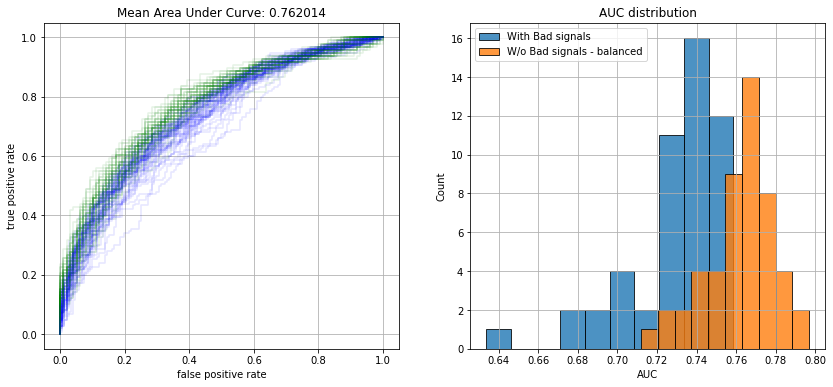

In [24]:
print(AUCB_ar)

plt.figure(figsize=(14,6));
plt.subplot(121);
for i in range(NTrials):
    plt.plot(FPRT_ar[:sizeT_ar[i],i], TPRT_ar[:sizeT_ar[i],i], 'b-', alpha=0.1);
    plt.plot(FPRB_ar[:sizeB_ar[i],i], TPRB_ar[:sizeB_ar[i],i], 'g-', alpha=0.1);
plt.grid(True);
plt.xlabel('false positive rate');
plt.ylabel('true positive rate');
plt.title('Mean Area Under Curve: %f' % np.mean(AUCB_ar));

plt.subplot(122);
plt.hist(AUCT_ar,edgecolor='k',alpha=0.8,label='With Bad signals');
plt.hist(AUCB_ar,edgecolor='k',alpha=0.8,label='W/o Bad signals - balanced');
plt.title('AUC distribution');
plt.xlabel('AUC');
plt.ylabel('Count')
plt.grid(True);
plt.legend();

# Pre-processing for a new test dataset:


In [25]:
def remove_noisy_signals(data_in, tag_in, model_clust, criterion):
    
    labels = model_clust.predict(data_in[:,:,0]);
    
    data_out = data_in[labels==criterion,:,:];
    tag_out  =  tag_in[labels==criterion,:];
    
    return(data_out,tag_out);

In [26]:
freq_crit  = 100.;
thresh_FFT = 0.95;
label_keep = 1;

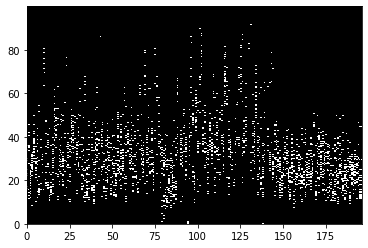

In [27]:
# Preprocess dataset:
freq, FFT_new,  y_new,  _, ID_new  = preprocess_data(TEST_PATH) # Enter your own path:

_, xf_new          = threshold_spectra(freq,freq_crit,FFT_train,FFT_new,thresh_FFT);
xft_new, yft_new   = remove_noisy_signals(xf_new, y_new, KMc, label_keep);

# Plot new dataset:
NTEST_new, _, _    = np.shape(xft_new);

XXcaseN, XXfreqN = np.meshgrid(np.arange(NTEST_new),freq[freq<=100],indexing='ij');
plt.pcolormesh(XXcaseN,XXfreqN,xft_new[:,:,0],cmap='gray');

# Discussion
**Please discuss the algorithm performance and explain the changes you made which led to performance gains.**

Many raw signals from the dataset had non-zero means. So the first thing I tried was to center individual recordings about their temporal means. I also standardized each signal about its RMS value. I tried to run the same CNN as already provided in the notebook but saw very little change in AUC (see the process notebook). 

I also noticed the signals are not synchronized in time, have different heart rates, so simple signal processing (ensemble averages) might not work. Likewise, spectrograms of the average signal from each class might not show meaningful differences. So I thought I could get better accuracy by instead looking at the global spectral content using FFTs. Since the Nyquist frequency will be half of the sampling frequency, the size of each case can be decreased. I also observed the energy content in most cases is confined to a small band of frequencies in range of [0-100] Hz: the "no murmur" class has a generally broader-band, albeit sparser, response compared to the "murmur" class. Most cases seem to have no response in the [0-10] Hz range -- so this gave me a rationale for truncating a big part of the spectrum and reducing the dataset dimensionality (10000 to 501 per case -- 20x reduction). Some cases, on the other hand, have response largely in the [0-10] Hz range (see, for example, case ID ~ [20 - 450] in no murmur). Such a group is also observed in the murmur class (ID: [250-300]). While this group is a minority in the training set (<20%), it forms a sizable chunk (~30%) of the test set -- so accuracy might be negatively impacted due to this. To try to remedy this, i oversampled more cases from this subset so that the classifier is not overly biased against it. I also thresholded the FFT spectra from continuous values to binary [0/1] arrays in the 95th percentile of energy content in the training set.

This reduction in dataset sped up each epoch for training the CNN from 26 sec to around 1 sec -- 20x reduction. I was also able to do a grid search cross-validation of the neural net using this reduced dataset (while it tended to overfit the model to the training set, doing a CV would have been impossible on my resources with 20x larger dataset and 10x greater training times). The AUC of the code provided by John was higher on average than ones I got from each technique I tried, but in the end I was able to significantly speed up the neural net and training which cost about 7% average AUC (0.78 vs 0.73)

Model accuracy can be improved by removing highly noisy signals: This was done using a KMeans clustering model which accurately removed the signals with spurious low frequency components. After removing such cases, AUC increased to 0.788. 

**Please discuss other things you would try if you had additional time that might further improve performance.**

I would have liked to try synchronizing the signals and scaling time so that each cardiac cycle ranges between time = [0,1]. Then I would have felt more comfortable working with time-series or spectrograms, so that I would get both temporal and spectral information.

I would also like to try different convolution filter sizes within one CNN model to mimic multiresolution analysis in some sense (Not sure this is traditionally done with CNNs).

Finally, cross-validation on the synchronized and normalized signals. 